In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas
from sklearn.preprocessing import StandardScaler

# Read in Data and Plot Histograms

In [2]:
X_y = np.load('skewed_MNIST.npy')
X = X_y[:,:-1]
y = X_y[:,-1]
print(X.shape, y.shape)

(12244, 784) (12244,)


Text(0, 0.5, 'frequency')

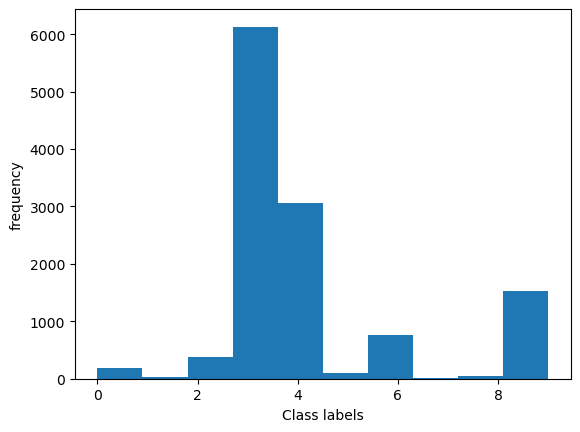

In [3]:
plt.hist(y)
plt.xlabel('Class labels')
plt.ylabel('frequency')

# Scale and PCA Data

In [4]:
# Scale X and store in X_scaled
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to scaled data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Helper Functions

In [5]:
def find_new_cluster_center(mu, p, m):
    '''
    Function Defined to find new cluster centers (V) using fuzzy matrix
    p( points ) and m (fuzzy constant)
    
    Inputs:
    
    mu: Old mu matrix containing previous fuzzy values, size = (n points, k clusters)
    p: Points of data, size = (n points, d dimensions)
    m: Fuzzy contant, scalar
    
    Outputs:
    
    v: Means of Clusters, each row represents the kth cluster, each column represents
        the d'th dimension
        shape = (k clusters, d dimensions)
    '''
    
    # Initialize v matrix
    v = np.zeros(shape = (mu.shape[1], p.shape[1]))
    
    # Iterate through clusters
    for k in range(mu.shape[1]):
        # Initialize numerator 
        numerator = np.zeros((1, p.shape[1]))
        
        # Iterate through points
        for n in range(p.shape[0]):
            # Multiply points by respective mu index using broadcasting (all p multiply by one mu index)
            numerator += np.power(mu[n,k], m) * p[n,:]
        
        # Sum all values of k'th cluster column in mu matrix    
        denominator = np.sum(np.power(mu[:,k], m))
        
        # Fill k'th cluster row in means matrix
        v[k, :] = numerator / denominator
    
    return v

In [6]:
def update_fuzzy_matrix(mu, p, v, m):
    '''
    Function Defined to update fuzzy matrix which is used to determine
    probabilities of points being in each cluster
    
    Inputs:
    
    mu: Old mu matrix containing previous fuzzy values, size = (n points, k clusters)
    p: Points of data, size = (n points, d dimensions)
    v: Means of Clusters, each row represents the kth cluster, each column represents
        the d'th dimension, shape = (k clusters, d dimensions)
    m: Fuzzy contant, scalar
    
    Outputs:
    
    mu: Updated mu matrix containing previous fuzzy values, size = (n points, k clusters)
    
    '''
    
    # Determine power for denominator
    a = 2 / (m - 1)
    
    # Iterate through all points
    for n in range(p.shape[0]):
        # Iterate through all clusters
        for k in range(mu.shape[1]):
            # Determine numerator for k'th cluster
            num = np.linalg.norm(p[n,:] - v[k, :])
            
            # Initialize sum for the inside of brackets which gets taken to a power
            sum_inside = 0.
            
            # Iterate through all clusters again to represent summation
            for l in range(mu.shape[1]):
                # Find distance between points and cluster means
                den = np.linalg.norm(p[n,:] - v[l,:])
                inside = num / den
                sum_inside += np.power(inside, a)
                
            # Update index
            mu[n,k] = 1. / sum_inside
        
    return mu

In [7]:
def fuzzy_cmeans_loss(mu, p, v, m):
    '''
    Function Defined to determine the loss for Fuzzy C-Means Clustering Algorithm
    
    Inputs:
    
    mu: Old mu matrix containing previous fuzzy values, size = (n points, k clusters)
    p: Points of data, size = (n points, d dimensions)
    v: Means of Clusters, each row represents the kth cluster, each column represents
        the d'th dimension, shape = (k clusters, d dimensions)
    m: Fuzzy contant, scalar
    
    Outputs:
    
    J: Loss of Fuzzy C-Means Clustering Alogorithm, Scalar
    
    '''
    
    # Initialize J
    J = 0
    
    # Iterate through points
    for n in range(p.shape[0]):
        # Iterate through clusters
        for k in range(mu.shape[1]):
            # Find squared distance of point from cluster mean
            norm_val = np.power(np.linalg.norm(p[n,:] - v[k,:]), 2)
            
            # Increment J each point and cluster
            J += np.power(mu[n,k], m) * norm_val
            
    return J

In [8]:
# Implment fuzzy c-means clustering from scratch

def fcm(X, n_clusters, max_iter=100, m=2, error=1e-5, random_state=42):
    '''
    Function Defined to determine to implement the Fuzzy C-Means Clustering Algorithm
    on the data X, into n_clusters 
    
    Inputs:
    
    X: Data to be clustered, shape = (n points, d dimensions)
    n_clusters: Scalar of amount of clusters
    max_iteration: Max iterations before exiting algorithm if not converged
    m: Scalar of fuzzy constant
    error: Scalar used to determine Convergence in Algorithm
    random_state: Fuzzy matrix is initially randomly generated, so random state 
                  allows replicability
    
    Outputs:
    
    mu: Final fuzzy matrix: size = (n points, k clusters)
    v: Final cluster means: size = (k clusters, d dimensions)
    
    '''
    # Initialize iteration tracker and loss list
    iter = 0
    J = [1000, 0]
    
    # Generate random fuzzy matrix of values between [0,1)
    mu = np.random.uniform(low=0.25, high=1, size=(X.shape[0], n_clusters))
    
    # Normalize rows to sum to 1, as probability being in all cluster must be 1
    for i in range(mu.shape[0]):
        mu[i,:] = mu[i,:] / np.sum(mu[i,:])
    
    # Iterate until convergence or max iteration hit
    while((np.abs(J[iter]- J[iter+1]) > error) and (iter < max_iter)):
        # Update cluster mean locations
        v = find_new_cluster_center(mu, X, m)
        
        # Calculate new fuzzy matrix
        mu = update_fuzzy_matrix(mu, X, v, m)
        
        # Determine loss for iteration and append to list
        J.append( fuzzy_cmeans_loss(mu, X, v, m) )
        
        # Increment iteration tracker
        iter += 1
        
        # Print to allow visual representation of where algorithm is when running
        print(f'Iteration: {iter},  J: {J[iter+1]:.6f}')
        
    return mu, v

In [9]:
def ARI(y, y_pred):
    '''
    Function defined to calculate the Rand Index. This algorithm determines
    the simularities and differences in which points are either within the same cluster
    or not and compares both the true labels and predicted labels. This is required because
    predicted clusters are not assumed to be consistent.
    
    Inputs:
    
    y: True Labels
    y_pred: Predicted Labels
    
    '''
    
    # Initialize comparison values
    n_00 = 0.
    n_11 = 0.
    n_10 = 0.
    n_01 = 0.
    
    # Initialize comparison matrices
    true = np.zeros((len(y), len(y)))
    pred = np.zeros((len(y), len(y)))
    
    # Iterate through labels
    for i in range(true.shape[0]):
        # Iterate through labels
        for j in range(true.shape[0]):
            # Check if points in true labels are in same cluster
            if(y[i] == y[j]):
                true[i,j] = 1
            
            # Check if points in predicted labels are in same cluster
            if(y_pred[i] == y_pred[j]):
                pred[i,j] = 1
    
    # Iterate through upper triangular of true and predicted comparison matrix
    for i in range(true.shape[0]):
        for j in range(i+1, true.shape[1]):
            # Check if true index value is same as predicted index value
            if(true[i,j] == pred[i,j]):
                # Both are in same cluster 
                if(true[i,j] == 1):
                    n_11 += 1.
                # Both are not in same cluster
                else:
                    n_00 += 1.
            # Index values are not the same        
            else:
                # Same clusters in true but different clusters in pred
                if(true[i,j] == 1):
                    n_10 += 1.
                # Different clusters in true but same clusters in pred
                else:
                    n_01 += 1.

    # Calculate rand index value
    ari = (n_00 + n_11) / (n_00 + n_11 + n_10 + n_11)
    
    return ari

# Simulations

In [10]:
# Variables for Next 3 Blocks

iterations = 30
ari_pca = []
ari_scaled = []
ari_original = []
cluster_vals = [2,3,4,5,6,7,8,9,10]
loop_range = int(len(cluster_vals) / 3)

# X_pca

Iteration: 1,  J: 477547.644422
Iteration: 2,  J: 477546.829468
Iteration: 3,  J: 477543.909904
Iteration: 4,  J: 477529.895563
Iteration: 5,  J: 477453.235547
Iteration: 6,  J: 477008.491611
Iteration: 7,  J: 474433.509286
Iteration: 8,  J: 461283.928337
Iteration: 9,  J: 420672.541861
Iteration: 10,  J: 382056.910567
Iteration: 11,  J: 374210.507005
Iteration: 12,  J: 373681.730370
Iteration: 13,  J: 373652.636191
Iteration: 14,  J: 373649.107518
Iteration: 15,  J: 373648.057080
Iteration: 16,  J: 373647.663891
Iteration: 17,  J: 373647.512416
Iteration: 18,  J: 373647.453862
Iteration: 19,  J: 373647.431215
Iteration: 20,  J: 373647.422455
Iteration: 21,  J: 373647.419067
Iteration: 22,  J: 373647.417756
Iteration: 23,  J: 373647.417248
Iteration: 24,  J: 373647.417052
Iteration: 25,  J: 373647.416976
Iteration: 26,  J: 373647.416947
Iteration: 27,  J: 373647.416936
Iteration: 28,  J: 373647.416931
Iteration: 1,  J: 318360.809069
Iteration: 2,  J: 318338.264394
Iteration: 3,  J: 318

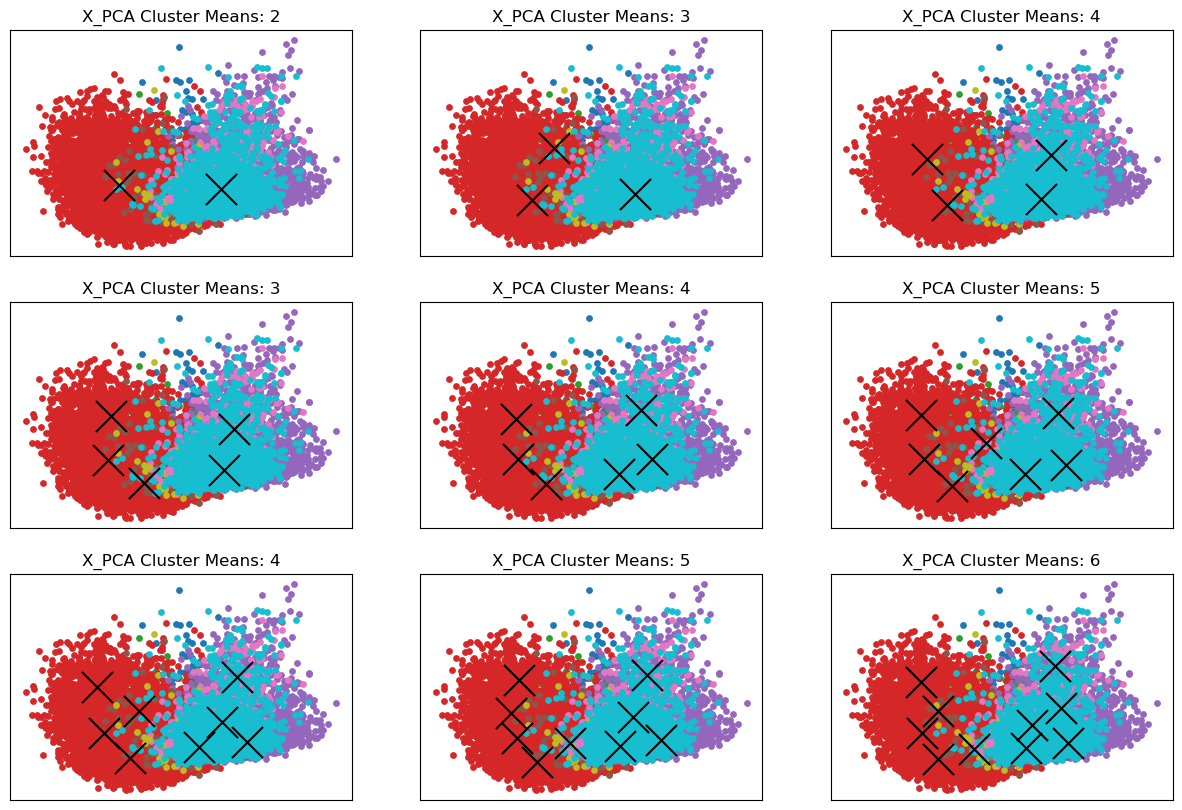

In [11]:
# Initialize subplot locations
fig, axes = plt.subplots(loop_range, loop_range, figsize=(15, 10),subplot_kw={'xticks': (), 'yticks': ()})

# Initialize cluster index
cluster_ind = 0

# Iterate through subplot index values
for i in range(loop_range):
    for j in range(loop_range):
        # Set Plot title by index value (BUG HERE)
        plot_title = 'X_PCA Cluster Means: ' + str(cluster_vals[i+j])
        csv_name = str(cluster_vals[cluster_ind]) + '_clusters_pca_fcm.csv'
        
        # Run clustering FCM algorthm
        mu, v = fcm(X_pca, cluster_vals[cluster_ind], iterations)
        
        # Iterate through all clusters
        for cl_num in np.unique(y):
            # Find y values which represent clusters
            inds = np.where(y == cl_num)[0]
            # Plot cluster values with respective color
            axes[i,j].scatter(X_pca[inds,0],X_pca[inds,1], marker='o', s=15)
            axes[i,j].set(title = plot_title)
        
        # Plot cluster means with large X
        axes[i,j].scatter(v[:, 0], v[:,1], marker='x', c= 'black', s=500)
        
        # Save cluster means to csv file
        v_df = pandas.DataFrame(v)
        v_df.to_csv(csv_name)     
        
        # Determine rand index value and append to list for later
        y_pred = np.argmax(mu, axis=1)
        ari_pca.append(ARI(y, y_pred))
        
        cluster_ind += 1   

In [12]:
# Print ARI values for respective cluster amounts
print('Adjusted Random Index for X_PCA:\n')
for i in range(len(cluster_vals)):
    print(f'{cluster_vals[i]} Clusters:\t{ari_pca[i]:.4f}')

Adjusted Random Index for X_PCA:

2 Clusters:	0.6927
3 Clusters:	0.6799
4 Clusters:	0.6809
5 Clusters:	0.6739
6 Clusters:	0.6766
7 Clusters:	0.6766
8 Clusters:	0.6753
9 Clusters:	0.6726
10 Clusters:	0.6737


# X_Scaled

In [13]:
# Iterate through cluster amounts 
for i in range(len(cluster_vals)):
    csv_name = str(cluster_vals[i]) + '_clusters_scaled_fcm.csv'
    
    # Run FCM clustering algorithm
    mu, v = fcm(X_scaled, cluster_vals[i], iterations)
    
    # Same means to csv
    v_df = pandas.DataFrame(v)
    v_df.to_csv(csv_name)   
    
    # Determine ARI and append to list for later
    y_pred = np.argmax(mu, axis=1)
    ari_scaled.append(ARI(y, y_pred))

Iteration: 1,  J: 4065090.804841
Iteration: 2,  J: 4065008.997227
Iteration: 3,  J: 4065008.052272
Iteration: 4,  J: 4065008.003147
Iteration: 5,  J: 4065008.000229
Iteration: 6,  J: 4065008.000023
Iteration: 7,  J: 4065008.000003
Iteration: 8,  J: 4065008.000001
Iteration: 1,  J: 2710072.908122
Iteration: 2,  J: 2710005.834349
Iteration: 3,  J: 2710005.363126
Iteration: 4,  J: 2710005.336434
Iteration: 5,  J: 2710005.333788
Iteration: 6,  J: 2710005.333412
Iteration: 7,  J: 2710005.333348
Iteration: 8,  J: 2710005.333336
Iteration: 9,  J: 2710005.333334
Iteration: 1,  J: 2032549.773444
Iteration: 2,  J: 2032504.602463
Iteration: 3,  J: 2032504.084475
Iteration: 4,  J: 2032504.014897
Iteration: 5,  J: 2032504.002750
Iteration: 6,  J: 2032504.000514
Iteration: 7,  J: 2032504.000096
Iteration: 8,  J: 2032504.000018
Iteration: 9,  J: 2032504.000003
Iteration: 10,  J: 2032504.000001
Iteration: 1,  J: 1626050.922534
Iteration: 2,  J: 1626003.922837
Iteration: 3,  J: 1626003.302435
Iteration

In [14]:
# Print respective ARI for cluster amounts
print('Adjusted Random Index for X_Scaled:\n')
for i in range(len(cluster_vals)):
    print(f'{cluster_vals[i]} Clusters:\t{ari_scaled[i]:.4f}')

Adjusted Random Index for X_Scaled:

2 Clusters:	0.6884
3 Clusters:	0.6938
4 Clusters:	0.6922
5 Clusters:	0.6922
6 Clusters:	0.6903
7 Clusters:	0.6917
8 Clusters:	0.6923
9 Clusters:	0.6922
10 Clusters:	0.6713


# X_Original

Iteration: 1,  J: 20377935990.483810
Iteration: 2,  J: 20377657939.726784
Iteration: 3,  J: 20377651487.804836
Iteration: 4,  J: 20377650026.582542
Iteration: 5,  J: 20377649577.356102
Iteration: 6,  J: 20377649434.307331
Iteration: 7,  J: 20377649388.515606
Iteration: 8,  J: 20377649373.844608
Iteration: 9,  J: 20377649369.143604
Iteration: 10,  J: 20377649367.636940
Iteration: 11,  J: 20377649367.154572
Iteration: 12,  J: 20377649366.999668
Iteration: 13,  J: 20377649366.950249
Iteration: 14,  J: 20377649366.934372
Iteration: 15,  J: 20377649366.929180
Iteration: 16,  J: 20377649366.927608
Iteration: 17,  J: 20377649366.927017
Iteration: 18,  J: 20377649366.926731
Iteration: 19,  J: 20377649366.926781
Iteration: 20,  J: 20377649366.926685
Iteration: 21,  J: 20377649366.926712
Iteration: 22,  J: 20377649366.926910
Iteration: 23,  J: 20377649366.926750
Iteration: 24,  J: 20377649366.926880
Iteration: 25,  J: 20377649366.926937
Iteration: 26,  J: 20377649366.926937
Iteration: 1,  J: 135

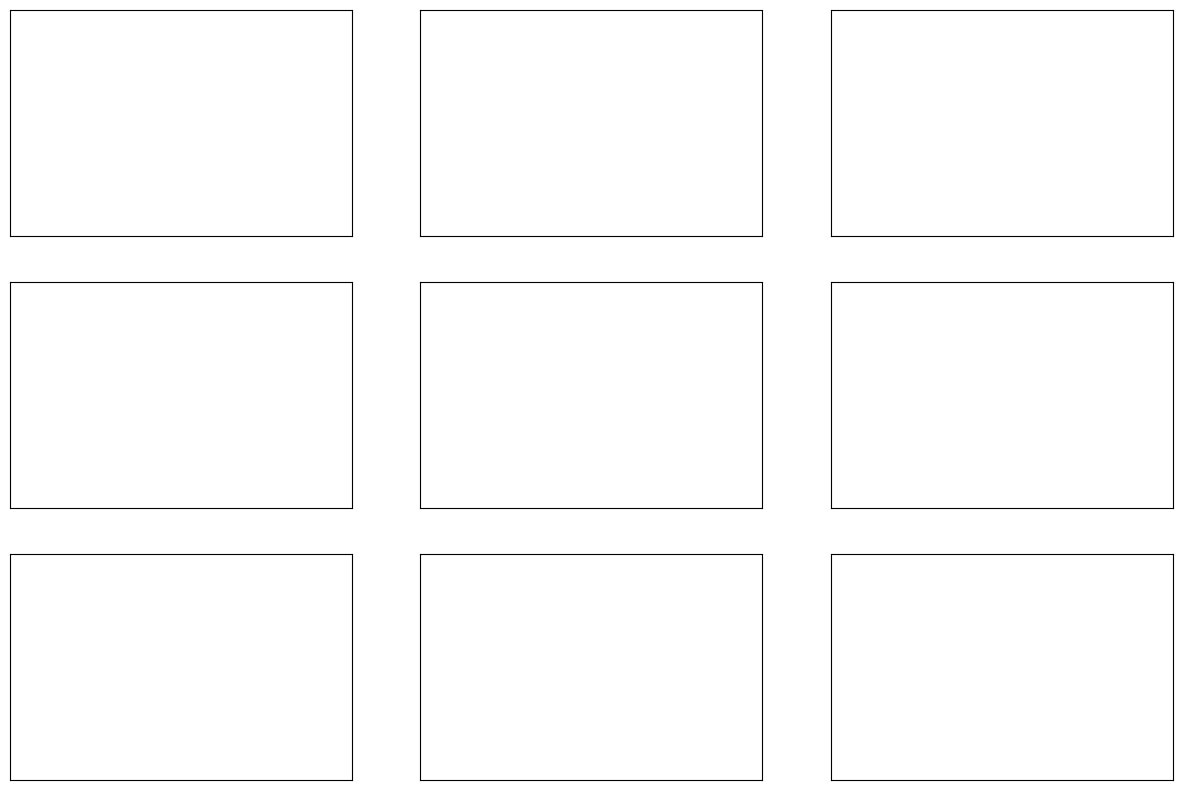

In [15]:
# Iterate through cluster amounts
for i in range(len(cluster_vals)):
    csv_name = str(cluster_vals[i]) + '_clusters_original_fcm.csv'
    
    # Run FCM clustering algorithm
    mu, v = fcm(X, cluster_vals[i], 30)
    
    # Save means to csv
    v_df = pandas.DataFrame(v)
    v_df.to_csv(csv_name)   
    
    # Determine ARI and append to list for later
    y_pred = np.argmax(mu, axis=1)
    ari_original.append(ARI(y, y_pred))


In [16]:
# Print Respective ARI Values for cluster amounts
print('Adjusted Random Index for X_Original:\n')
for i in range(len(cluster_vals)):
    print(f'{cluster_vals[i]} Clusters:\t{ari_original[i]:.4f}')

Adjusted Random Index for X_Original:

2 Clusters:	0.6922
3 Clusters:	0.6922
4 Clusters:	0.6922
5 Clusters:	0.6922
6 Clusters:	0.6922
7 Clusters:	0.6922
8 Clusters:	0.6922
9 Clusters:	0.6922
10 Clusters:	0.6922
